# A notebook to to get true and predicted CTann and RUI for HRApop atlas datasets


## Goal

See [this GitHub issue](https://github.com/x-atlas-consortia/hra-pop/issues/100)


## Import libraries


In [1]:
%pip install requests pandas seaborn matplotlib scipy scikit-learn hra_api_client ipywidgets IPython

import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pprint import pprint
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from ipywidgets import IntProgress
from IPython.display import display

Note: you may need to restart the kernel to use updated packages.


In [2]:
import hra_api_client

from hra_api_client.api import v1_api as default_api
from hra_api_client.models.sparql_query_request import SparqlQueryRequest

Configure HRA API client and create API instance

In [3]:
# may need to remove `v1`
configuration = hra_api_client.Configuration(
    host="https://apps.humanatlas.io/api"
)

api_client = hra_api_client.ApiClient(configuration)
api_instance = default_api.V1Api(api_client)

## Set global variables


In [4]:
hra_pop_version = "v0.11.1"

## Load data


In [5]:
# df_x = pd.read_csv("data/validation-v7-ctann-rui.csv")
df_x = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-x-axis.csv")
df_y = pd.read_csv(
  f"../../../hra-pop/output-data/{hra_pop_version}/reports/atlas/validation-v7-y-axis.csv")

## Prepare data for visualization and visualize


In [6]:
df_x

,sex,sample,rui_location,dataset,tool,modality,organ,organId,datasetVsRuiSim
0,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.950561
1,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.943954
2,Female,https://doi.org/10.1126/science.abl4290#GTEX-1...,http://purl.org/ccf/1.5/3b5d2036-3c56-4cf8-808...,https://doi.org/10.1126/science.abl4290#GTEX-1...,popv,sc_transcriptomics,Set of lactiferous glands in right breast,FMA:57987,0.935120
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952
...,...,...,...,...,...,...,...,...,...
988,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.956401
989,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/0060612c-6d95-47d8-a8d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.873417
990,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/1fa8bd4e-49af-4121-a1b...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.984704
991,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/cc08d64c-5d75-4995-b3b...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.991414


In [7]:
df_y

,sex,rui_location,dataset,tool,predicted_rui,similarity
0,Female,http://purl.org/ccf/1.5/4ecffbfc-dc50-4140-95e...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/9d795171-ba1f-4ae2-9b9...,0.999609
1,Female,http://purl.org/ccf/1.5/fd380a0c-2915-4d73-b3f...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/bd004aeb-6e60-4d5b-8d4...,0.971000
2,Male,http://purl.org/ccf/1.5/594902fb-c4c1-47c3-b98...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3...,0.985963
3,Male,http://purl.org/ccf/1.5/7f0bfe51-5458-4ef8-864...,https://entity.api.hubmapconsortium.org/entiti...,celltypist,http://purl.org/ccf/1.5/82566926-7a8f-43a7-9f6...,0.787838
4,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,https://entity.api.hubmapconsortium.org/entiti...,celltypist,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adb...,0.867706
...,...,...,...,...,...,...
1008,Male,http://purl.org/ccf/1.5/615aa60c-0a0a-4614-bae...,https://doi.org/10.1016/j.cell.2022.12.028#CRC...,sc_proteomics,http://purl.org/ccf/1.5/8e8d9121-3a47-4c89-9e6...,0.993595
1009,Male,http://purl.org/ccf/1.5/9bd653dd-2309-4ecc-b4c...,https://api.cellxgene.cziscience.com/dp/v1/col...,popv,http://purl.org/ccf/1.5/1995aefd-5289-4652-a7e...,0.851110
1010,Male,http://purl.org/ccf/1.5/ba9d007b-c5c7-4231-80f...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/c89a4a3c-52d7-4508-86f...,0.995785
1011,Male,http://purl.org/ccf/1.5/d51b9d67-837f-4451-a6c...,https://entity.api.hubmapconsortium.org/entiti...,celltypist,http://purl.org/ccf/1.5/c9e06f93-152f-4c72-aa6...,0.919764


## Compute similarity scores for %AS


### Load atlas enriched dataset graph


In [8]:
ds_graph_path = f"../../../hra-pop/output-data/{hra_pop_version}/atlas-enriched-dataset-graph.jsonld"

with open(ds_graph_path) as f:
  graph = json.load(f)

### Define functions


In [9]:

def dict_to_vec(dict1: dict, dict2: dict):
  """Takes two dictionaries and returns a tuple of nornalized lists with values (0 if key not present)
  Args:
    dict1 (dict): dictionary 1
    dict2 (dict): dictionary 2

  Returns:
    result (tuple): a tuple with normalized lists
  """

  # initialize result
  dict1_list = []
  dict2_list = []

  # handle shared keys
  shared_keys = set(dict1['collisions'].keys()).intersection(
    dict2['collisions'].keys())

  for key in shared_keys:
    dict1_list.append(dict1['collisions'][key])
    dict2_list.append(dict2['collisions'][key])

  # handle not shared keys
  keys_in_dict1_not_in_dict2 = dict1.keys() - dict2.keys()
  for key in keys_in_dict1_not_in_dict2:
    dict1[key] = 0
  keys_in_dict2_not_in_dict1 = dict2.keys() - dict1.keys()
  for key in keys_in_dict2_not_in_dict1:
    dict1[key] = 0
  return (dict1_list, dict2_list)


def get_as_collision_items(iri: str, get_organ = False):
  """A function to get AS collision items for an IRI (extraction site) and return a dictionary with AS UBERON ID and intersection percentage of the extraction site. 
  This uses https://apps.humanatlas.io/api/#get-/v1/extraction-site to get the rui_location data given the IRI and https://apps.humanatlas.io/api/#post-/v1/collisions to get the collisions

  Args:
    iri (str): an IRI for an extraction site

  Returns:
    a dictionary with the IRI and a nested dictionary with collisions (ID and percentage) 
  """
  result = {
  }

  # get extraction site
  # base_url_extraction_site = "https://apps.humanatlas.io/api/v1/extraction-site?iri="
  # extraction_site = ""
  # response = requests.get(base_url_extraction_site+iri)
  # extraction_site = api_instance.extraction_site(iri)

  try:
    # extraction_site = json.loads(response)
    extraction_site = api_instance.extraction_site(iri)
  except Exception as e:
    print(f"Non-success status code given {iri}: {e}")
    return result  # Or use an empty dictionary, or any other placeholder
  
  try:
    # send extraction site to /collisions endpoints
    collisions = api_instance.collisions(extraction_site)
    for item in collisions:
      result[item['representation_of']] = item['percentage_of_tissue_block']

    if get_organ:
        result['organ'] = extraction_site['placement']['target']
  except Exception as e:
    print(f"Collision error with IRI {iri}: {e}")
    return result  # Or use an empty dictionary, or any other placeholder

  return result


def compute_cosine_similarity_by_as_percentage(iri_1: str, iri_2: str):
  """Takes two IRIs of extraction sites and returns the cosine similarity of their AS percentages

  Args:
          iri_1 (str): An IRI for an extraction site
          iri_2 (str): An IRI for an extraction site

Returns: 
          similarity (float): A cosine similarity
  """

  # Get AS collision items as dict
  dict1 = get_as_collision_items(iri_1)
  dict2 = get_as_collision_items(iri_2)

  # Get a combined set of all keys from both dictionaries
  all_keys = set(dict1.keys()).union(dict2.keys())

  # Create the two lists of values
  values1 = [dict1.get(key, 0) for key in all_keys]
  values2 = [dict2.get(key, 0) for key in all_keys]

  # Compute cosine similarity
  cosine_similarity_value = cosine_similarity([values1], [values2])
  # print(f"Got new sim: {cosine_similarity_value}")
  return float(cosine_similarity_value[0][0])

### Loop through pairs of extraction sites (true and predicted) in validation and compute AS% similarity score


In [10]:
# handle exception for extraction site endpoint
# set up session. Can add HuBMAP token after ?token= to get private data
session_configuration = {"dataSources": [
    "https://apps.humanatlas.io/api/ds-graph/hubmap",
    "https://apps.humanatlas.io/api/ds-graph/sennet",
    "https://apps.humanatlas.io/api/ds-graph/gtex",
    "https://hubmapconsortium.github.io/hra-registrations/federated/rui_locations.jsonld",
    "https://hubmapconsortium.github.io/hra-registrations/vccf-federated/rui_locations.jsonld",
    "https://hubmapconsortium.github.io/hra-registrations/staging/kpmp-kidney-jain-2023/rui_locations.jsonld"
]}

# Get a session token for this configuration
api_response = api_instance.session_token(session_configuration)
token = api_response.token
print(token)

0176e1be3749fdb60dd16b42791f8377


In [11]:
db_ready = False
while not db_ready:
    api_response = api_instance.db_status(token)
    print(api_response)
    if api_response.status == 'Ready':
        db_ready = True
    else:
        print('Database not ready yet! Retrying...')
        time.sleep(2)

status='Loading' checkback=2000 load_time=295 message='Job is queued to be run...'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=2609 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=4797 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=6971 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=9069 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=11380 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=13495 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=15669 message='Adding dataset'
Database not ready yet! Retrying...
status='Loading' checkback=2000 load_time=17880 message='Adding dataset'
Database not ready yet! Retrying...
status='Loadi

In [12]:
# global counter
counter = 0

# instantiate progress bar
f = IntProgress(min=0, max=len(df_y.index))  

In [13]:
# Define a helper function with try-except logic
def safe_cosine_similarity(rui_location, predicted_rui):
  """A function to wrap compute_cosine_similarity_by_as_percentage with a try-except block

  Args:
      rui_location (_type_): _description_
      predicted_rui (_type_): _description_

  Returns:
      _type_: _description_
  """
  
  global counter 
  global f
  counter += 1
  f.value += 1 # signal to increment the progress bar
  
  print(f"Now at row {counter}")
  try:
      return compute_cosine_similarity_by_as_percentage(rui_location, predicted_rui)
  except Exception as e:
      print(f"Error computing similarity: {e} caused by {rui_location} and {predicted_rui}")
      return f"There was an exception." 


display(f)  # display the bar

# add new column with cosine similarity between true and predicted rui
df_y['as_percentage_cosine_sim'] = df_y.apply(
    lambda row: safe_cosine_similarity(
        row['rui_location'], row['predicted_rui']),
    axis=1
)

# Save to CSV for optional inspection in external software
df_y.to_csv("output/df_y.csv")

# print for review inline
df_y

IntProgress(value=0, max=1013)

Now at row 1
Now at row 2
Now at row 3
Now at row 4
Now at row 5
Now at row 6
Now at row 7
Now at row 8
Now at row 9
Now at row 10
Now at row 11
Now at row 12
Now at row 13
Now at row 14
Now at row 15
Now at row 16
Now at row 17
Now at row 18
Now at row 19
Now at row 20
Now at row 21
Now at row 22
Now at row 23
Now at row 24
Now at row 25
Now at row 26
Now at row 27
Now at row 28
Now at row 29
Now at row 30
Now at row 31
Now at row 32
Now at row 33
Now at row 34
Now at row 35
Now at row 36
Now at row 37
Now at row 38
Now at row 39
Now at row 40
Now at row 41
Now at row 42
Now at row 43
Now at row 44
Now at row 45
Now at row 46
Now at row 47
Now at row 48
Now at row 49
Now at row 50
Now at row 51
Now at row 52
Now at row 53
Now at row 54
Now at row 55
Now at row 56
Now at row 57
Now at row 58
Now at row 59
Now at row 60
Now at row 61
Now at row 62
Now at row 63
Now at row 64
Now at row 65
Now at row 66
Now at row 67
Now at row 68
Now at row 69
Now at row 70
Now at row 71
Now at row 72
N

,sex,rui_location,dataset,tool,predicted_rui,similarity,as_percentage_cosine_sim
0,Female,http://purl.org/ccf/1.5/4ecffbfc-dc50-4140-95e...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/9d795171-ba1f-4ae2-9b9...,0.999609,1.0
1,Female,http://purl.org/ccf/1.5/fd380a0c-2915-4d73-b3f...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/bd004aeb-6e60-4d5b-8d4...,0.971000,0.664387
2,Male,http://purl.org/ccf/1.5/594902fb-c4c1-47c3-b98...,https://entity.api.hubmapconsortium.org/entiti...,azimuth,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3...,0.985963,1.0
3,Male,http://purl.org/ccf/1.5/7f0bfe51-5458-4ef8-864...,https://entity.api.hubmapconsortium.org/entiti...,celltypist,http://purl.org/ccf/1.5/82566926-7a8f-43a7-9f6...,0.787838,1.0
4,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b53...,https://entity.api.hubmapconsortium.org/entiti...,celltypist,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adb...,0.867706,0.98805
...,...,...,...,...,...,...,...
1008,Male,http://purl.org/ccf/1.5/615aa60c-0a0a-4614-bae...,https://doi.org/10.1016/j.cell.2022.12.028#CRC...,sc_proteomics,http://purl.org/ccf/1.5/8e8d9121-3a47-4c89-9e6...,0.993595,0.873305
1009,Male,http://purl.org/ccf/1.5/9bd653dd-2309-4ecc-b4c...,https://api.cellxgene.cziscience.com/dp/v1/col...,popv,http://purl.org/ccf/1.5/1995aefd-5289-4652-a7e...,0.851110,0.0
1010,Male,http://purl.org/ccf/1.5/ba9d007b-c5c7-4231-80f...,https://entity.api.hubmapconsortium.org/entiti...,popv,http://purl.org/ccf/1.5/c89a4a3c-52d7-4508-86f...,0.995785,0.0
1011,Male,http://purl.org/ccf/1.5/d51b9d67-837f-4451-a6c...,https://entity.api.hubmapconsortium.org/entiti...,celltypist,http://purl.org/ccf/1.5/c9e06f93-152f-4c72-aa6...,0.919764,0.0


In [24]:
# filter out rows with a string instead of float for sim
df_y_filtered_as_needed = df_y[~df_y['as_percentage_cosine_sim'].apply(lambda val: isinstance(val, str))]

df_y_filtered_as_needed

,sex,rui_location,dataset,tool,predicted_rui,similarity,as_percentage_cosine_sim
0,Female,http://purl.org/ccf/1.5/4ecffbfc-dc50-4140-95e8-4f97d5804f4f,https://entity.api.hubmapconsortium.org/entities/f6eb890063d13698feb11d39fa61e45a,popv,http://purl.org/ccf/1.5/9d795171-ba1f-4ae2-9b98-9a285280ebf6,0.999609,1.0
1,Female,http://purl.org/ccf/1.5/fd380a0c-2915-4d73-b3f4-d161badbaccb,https://entity.api.hubmapconsortium.org/entities/aa93e53df10842c13348a334c8fe423f,azimuth,http://purl.org/ccf/1.5/bd004aeb-6e60-4d5b-8d40-cfdd55b8b6fe,0.971000,0.664387
2,Male,http://purl.org/ccf/1.5/594902fb-c4c1-47c3-b98e-3101b93a73e4,https://entity.api.hubmapconsortium.org/entities/d171ff8d83f707ecca64ff159c7160a7,azimuth,http://purl.org/ccf/1.5/fd4fcec2-93c3-428f-ad3a-6c7ac4196da0,0.985963,1.0
3,Male,http://purl.org/ccf/1.5/7f0bfe51-5458-4ef8-8641-c3d9a5fbd538,https://entity.api.hubmapconsortium.org/entities/032d7b6b0b4c3c66772c7dbee2fe9606,celltypist,http://purl.org/ccf/1.5/82566926-7a8f-43a7-9f6a-ae0c463d7a1d,0.787838,1.0
4,Male,http://purl.org/ccf/1.5/aba1ebe3-af18-40cc-b536-b89843049ca5,https://entity.api.hubmapconsortium.org/entities/faa1acc13943ee9d365b6cc6a3ea889f,celltypist,http://purl.org/ccf/1.5/da60f474-614a-4e0a-adbe-521ba44c7bf0,0.867706,0.98805
...,...,...,...,...,...,...,...
1008,Male,http://purl.org/ccf/1.5/615aa60c-0a0a-4614-bae2-f85112479919,https://doi.org/10.1016/j.cell.2022.12.028#CRC01097,sc_proteomics,http://purl.org/ccf/1.5/8e8d9121-3a47-4c89-9e63-aec6659075d2,0.993595,0.873305
1009,Male,http://purl.org/ccf/1.5/9bd653dd-2309-4ecc-b4c8-e9f3de4bf8ca,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H4$l...,popv,http://purl.org/ccf/1.5/1995aefd-5289-4652-a7e0-cc66c495649f,0.851110,0.0
1010,Male,http://purl.org/ccf/1.5/ba9d007b-c5c7-4231-80f9-42403a98a6df,https://entity.api.hubmapconsortium.org/entities/cd0ad2f9ed2f896e682ecacfbdac01ab,popv,http://purl.org/ccf/1.5/c89a4a3c-52d7-4508-86fb-b7e5610cb1e0,0.995785,0.0
1011,Male,http://purl.org/ccf/1.5/d51b9d67-837f-4451-a6c6-0b63c7879736,https://entity.api.hubmapconsortium.org/entities/0b590c9e3a62178da592e85572e2f1bf,celltypist,http://purl.org/ccf/1.5/c9e06f93-152f-4c72-aa69-4b1176833af7,0.919764,0.0


## Visualize


### Create combined DataFrame


In [15]:
# Merging on columns
df_merged = pd.merge(
  df_x, df_y_filtered_as_needed, on=['dataset', 'tool', 'rui_location', 'sex'], how='inner')

# rename similarity columns for plotting
df_merged = df_merged.rename(columns={
  "datasetVsRuiSim": "ctann_sim",
  # RUI (y axis) cosine sim between dataset cell summary vs PREDICTED (most similar) rui location cell summary (*except* its TRUE rui location)
  "similarity": "rui_sim_by_cell_summary",
  "as_percentage_cosine_sim": "rui_sim_as_percentage"
})

df_merged

,sex,sample,rui_location,dataset,tool,modality,organ,organId,ctann_sim,predicted_rui,rui_sim_by_cell_summary,rui_sim_as_percentage
0,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356,http://purl.org/ccf/1.5/05c11830-1526-4472-bd1...,0.917636,0.532793
1,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.925033,0.0
2,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8a...,https://api.cellxgene.cziscience.com/dp/v1/col...,popv,sc_transcriptomics,heart,UBERON:0000948,0.941687,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2f...,0.969786,0.0
3,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.933921,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.978646,0.0
4,Female,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7...,https://api.cellxgene.cziscience.com/dp/v1/col...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.474365,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967...,0.916703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
980,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.956401,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b55...,0.956401,0.0
981,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/0060612c-6d95-47d8-a8d...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.873417,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a...,0.877549,0.917667
982,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/1fa8bd4e-49af-4121-a1b...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.984704,http://purl.org/ccf/1.5/0060612c-6d95-47d8-a8d...,0.984245,0.989202
983,Male,https://entity.api.hubmapconsortium.org/entiti...,http://purl.org/ccf/1.5/cc08d64c-5d75-4995-b3b...,https://entity.api.hubmapconsortium.org/entiti...,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.991414,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a...,0.991414,1.0


### Subset data (if needed)

In [16]:
pd.options.display.max_colwidth = 100

# set subset to full df
df_subset = df_merged

# insert any code here to subset if needed
# YOUR CODE HERE

# inspect
df_subset

,sex,sample,rui_location,dataset,tool,modality,organ,organId,ctann_sim,predicted_rui,rui_sim_by_cell_summary,rui_sim_as_percentage
0,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.911356,http://purl.org/ccf/1.5/05c11830-1526-4472-bd12-ea24dbcfd3cc,0.917636,0.532793
1,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.701952,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.925033,0.0
2,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,http://purl.org/ccf/1.5/9abfed4e-2fde-4d80-a8aa-7439a106d895,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$a...,popv,sc_transcriptomics,heart,UBERON:0000948,0.941687,http://purl.org/ccf/1.5/ca476545-5b98-476c-b2fd-1b8e1708faed,0.969786,0.0
3,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,azimuth,sc_transcriptomics,heart,UBERON:0000948,0.933921,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.978646,0.0
4,Female,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,http://purl.org/ccf/1.5/2156f837-2ab2-4305-8e7f-8084249e91cd,https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$h...,celltypist,sc_transcriptomics,heart,UBERON:0000948,0.474365,http://purl.org/ccf/1.5/1fe61622-ba53-47c9-967e-e764c21b8189,0.916703,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
980,Male,https://entity.api.hubmapconsortium.org/entities/734f394ab73a5b3974b394a366e48081,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a6-f972a70da51a,https://entity.api.hubmapconsortium.org/entities/578f1282276ddc1cc4c4817e4950f13c,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.956401,http://purl.org/ccf/1.5/b2aca02c-9559-4869-b551-4bfb59bf84b3,0.956401,0.0
981,Male,https://entity.api.hubmapconsortium.org/entities/a6920284fccd858507978948faca6d19,http://purl.org/ccf/1.5/0060612c-6d95-47d8-a8d0-0443fff344e9,https://entity.api.hubmapconsortium.org/entities/6c57274e7a40413dc042ec32442a228b,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.873417,http://purl.org/ccf/1.5/fb6bb0ea-5ba7-44e2-90a6-f972a70da51a,0.877549,0.917667
982,Male,https://entity.api.hubmapconsortium.org/entities/1b2b3790a9d91d88e5a7511b491025f8,http://purl.org/ccf/1.5/1fa8bd4e-49af-4121-a1b4-618af0b79d4c,https://entity.api.hubmapconsortium.org/entities/a44f5dbe2472dac447b0f91a24da8b30,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.984704,http://purl.org/ccf/1.5/0060612c-6d95-47d8-a8d0-0443fff344e9,0.984245,0.989202
983,Male,https://entity.api.hubmapconsortium.org/entities/4ff2d3993ea5aeeeb360d163ab217dc6,http://purl.org/ccf/1.5/cc08d64c-5d75-4995-b3b0-00239a742184,https://entity.api.hubmapconsortium.org/entities/d67c61063b82f6479e93133bdd8949fb,popv,sc_transcriptomics,urinary bladder,UBERON:0001255,0.991414,http://purl.org/ccf/1.5/e43280c9-840b-481f-a8a6-90114c2c5cc9,0.991414,1.0


### Build plot


Functions for making plots


In [17]:
def make_validation_scattergraph(x: float, y: float, palette: str, col: str, row: str, hue: str, x_label: str, y_label: str):
    """A wrapper function around a seaborn FacetGrid to make multiple versions of the validation scattergraph

    Args:
                    x (float): x-value
                    y (float): y-value
                    palette (str): Name for color palette
                    col (str): Column of facet grid
                    row (str): Row of facet grid
                    hue (str): Color for points
                    x_label (str): Label on x-axis
            y_label (str): Label on y-axis
    """

    # Create a custom color palette
    custom_palette = sns.color_palette(palette)

    # set font size
    sns.set_theme(font_scale=2)

    # Create FacetGrid
    g = sns.FacetGrid(
        df_subset,
        col=col,
        row=row,
        hue=hue,
        palette=custom_palette,
        height=5,
        aspect=2
    )

    # Set the style of the plot
    # Options: "white", "dark", "whitegrid", "darkgrid", "ticks"
    sns.set_style("whitegrid")

    # Create a scatter plot
    g.map(sns.scatterplot, x, y)

    # Set labels
    g.set(xlabel=x_label, ylabel=y_label)

    # Add a legend
    g.add_legend()

    # Show the plot
    plt.show()

### Data dictionary


| Axis             | Variable                | Explanation                                                                                                                                 |
| ---------------- | ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| x                | ctann_sim               | CTann (x axis) Cosine sim between TRUE cell summary of input dataset and PREDICTED cell summary of input RUI location (as computed by US 1) |
| y (cell summary) | rui_sim_by_cell_summary | (y axis) cosine sim between TRUE RUI cell summary vs PREDICTED (most similar cell type population) rui location cell summary |
| y (AS%)          | rui_sim_as_percentage   | RUI (y axis) cosine sim between AS% of TRUE and PREDICTED rui (determined by cosine sim captured as `ruiVsTopPredictedRuiSim` in [this query](https://github.com/x-atlas-consortia/hra-pop/blob/main/queries/atlas/validation-v7-ctann-rui.rq)). Could also use `datasetVsRuiSim`, which is the sim between a dataset and its OWN rui location                                            
                                  |


### CTann vs RUI AS% similarity


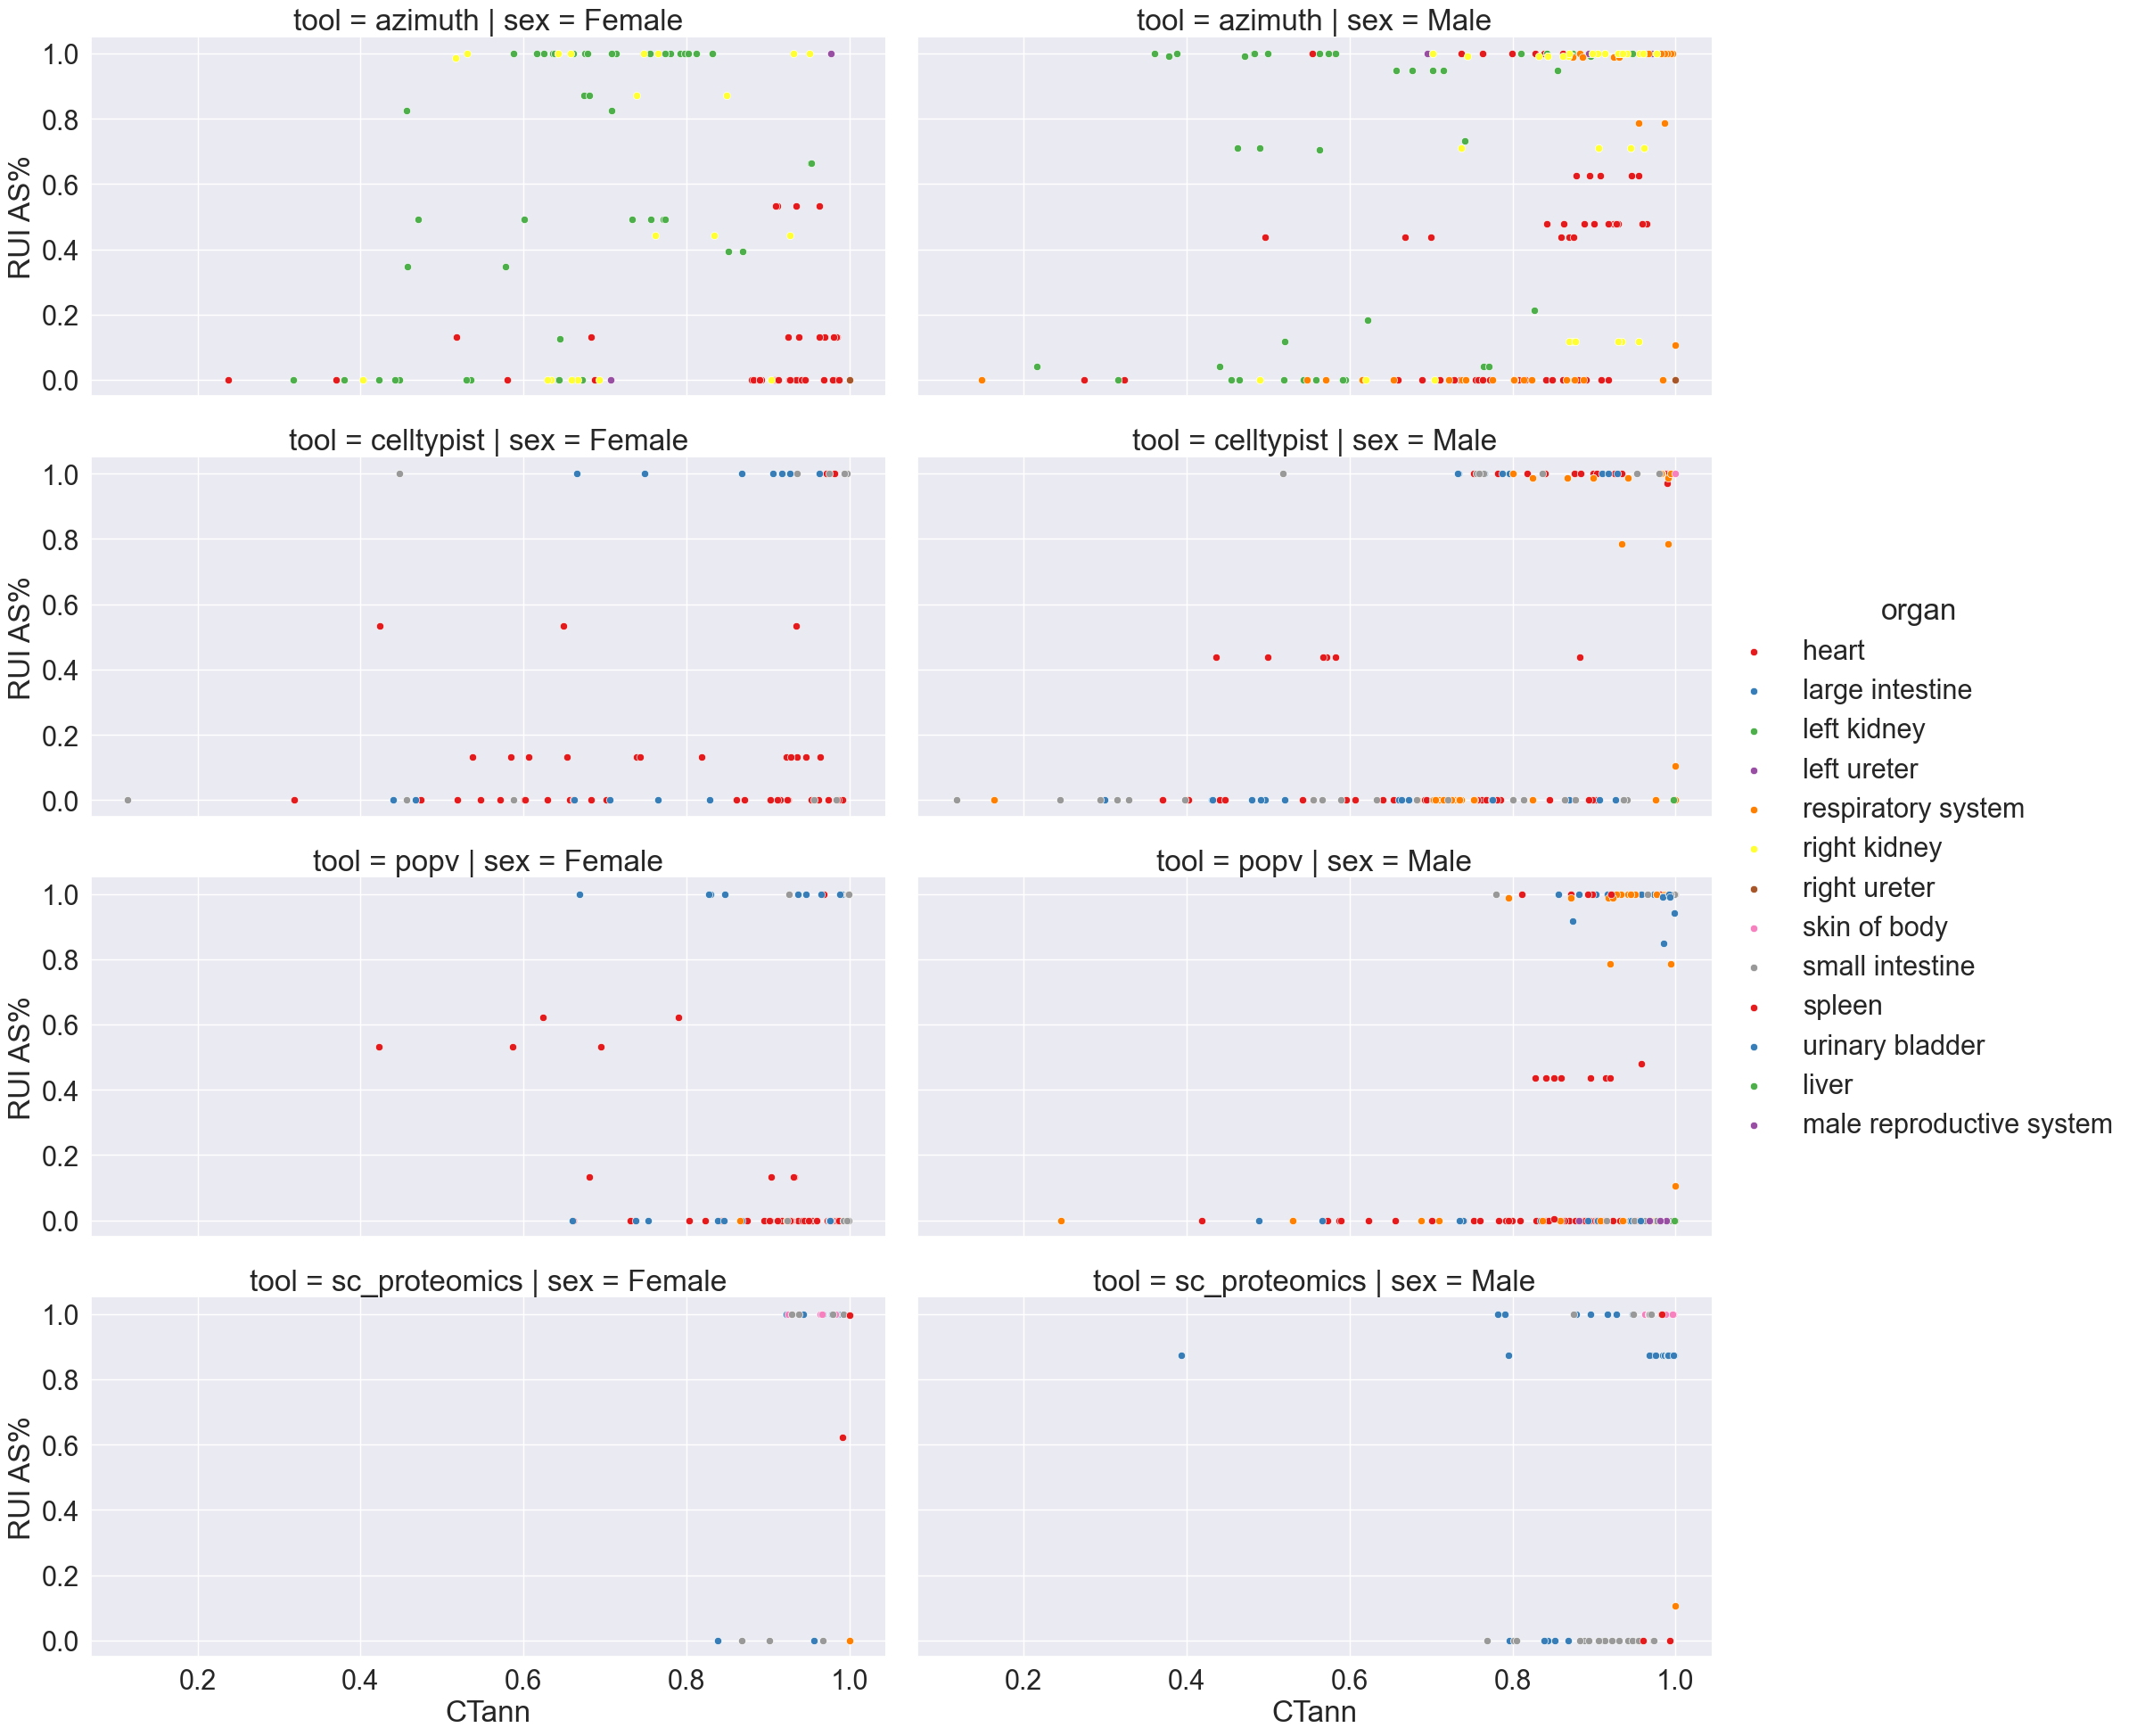

In [18]:
make_validation_scattergraph(
  "ctann_sim", "rui_sim_as_percentage", "Set1", "sex", "tool", "organ", "CTann", "RUI AS%")

In [19]:
# correlation
stats = df_subset[['ctann_sim', 'rui_sim_as_percentage',
                   'rui_sim_by_cell_summary']].astype(float)
stats.corr(min_periods=3)

,ctann_sim,rui_sim_as_percentage,rui_sim_by_cell_summary
ctann_sim,1.000000,0.222224,0.679291
rui_sim_as_percentage,0.222224,1.000000,0.078855
rui_sim_by_cell_summary,0.679291,0.078855,1.000000


In [20]:
# Mean, STDDEV, min, etc.
summary = stats.describe()
summary

,ctann_sim,rui_sim_as_percentage,rui_sim_by_cell_summary
count,985.000000,985.000000,985.000000
mean,0.830839,0.435387,0.865524
std,0.170987,0.461443,0.146929
min,0.113734,0.000000,0.117356
25%,0.737817,0.000000,0.812781
50%,0.892182,0.132641,0.916703
75%,0.960623,1.000000,0.967564
max,1.000000,1.000000,1.000000


## Visualize rui_sim_by_cell_summary vs rui_sim_as_percentage

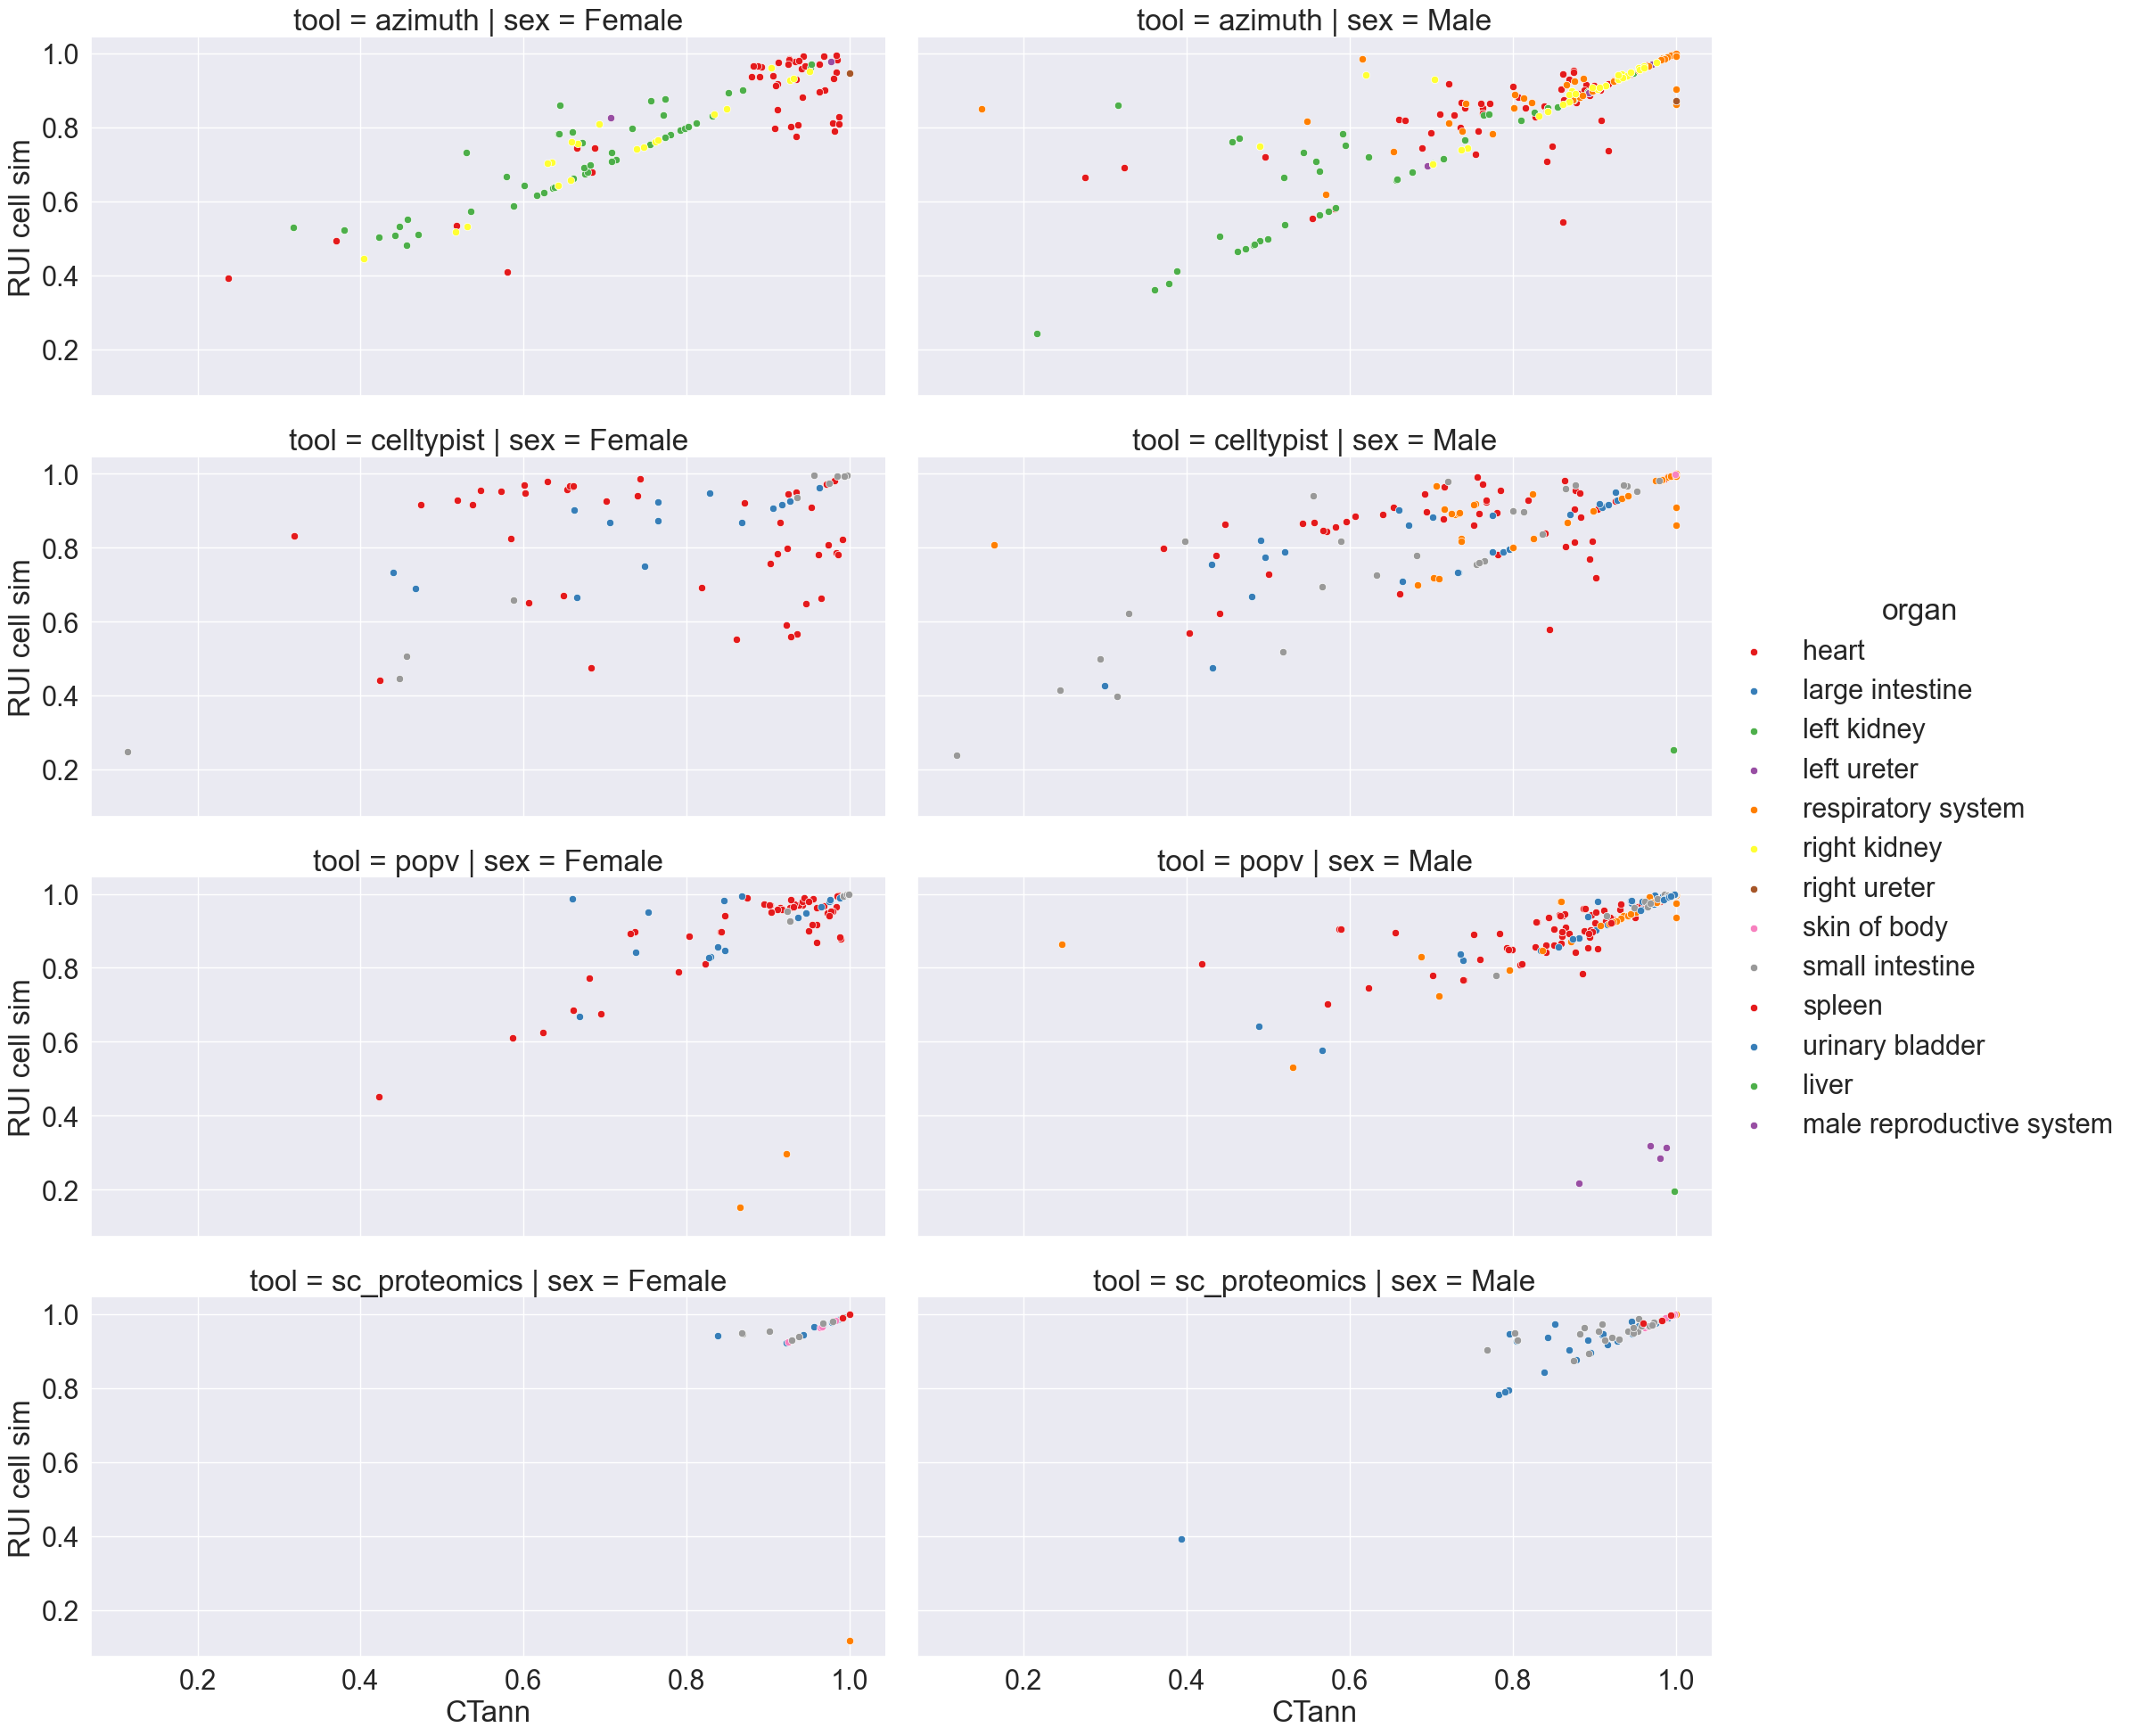

In [21]:
# make scattergraph of rui_sim_by_cell_summary vs rui_sim_as_percentage
make_validation_scattergraph(
    "ctann_sim", "rui_sim_by_cell_summary", "Set1", "sex", "tool", "organ", "CTann", "RUI cell sim")

## Visualize discrepancies between the two RUI sim metrics

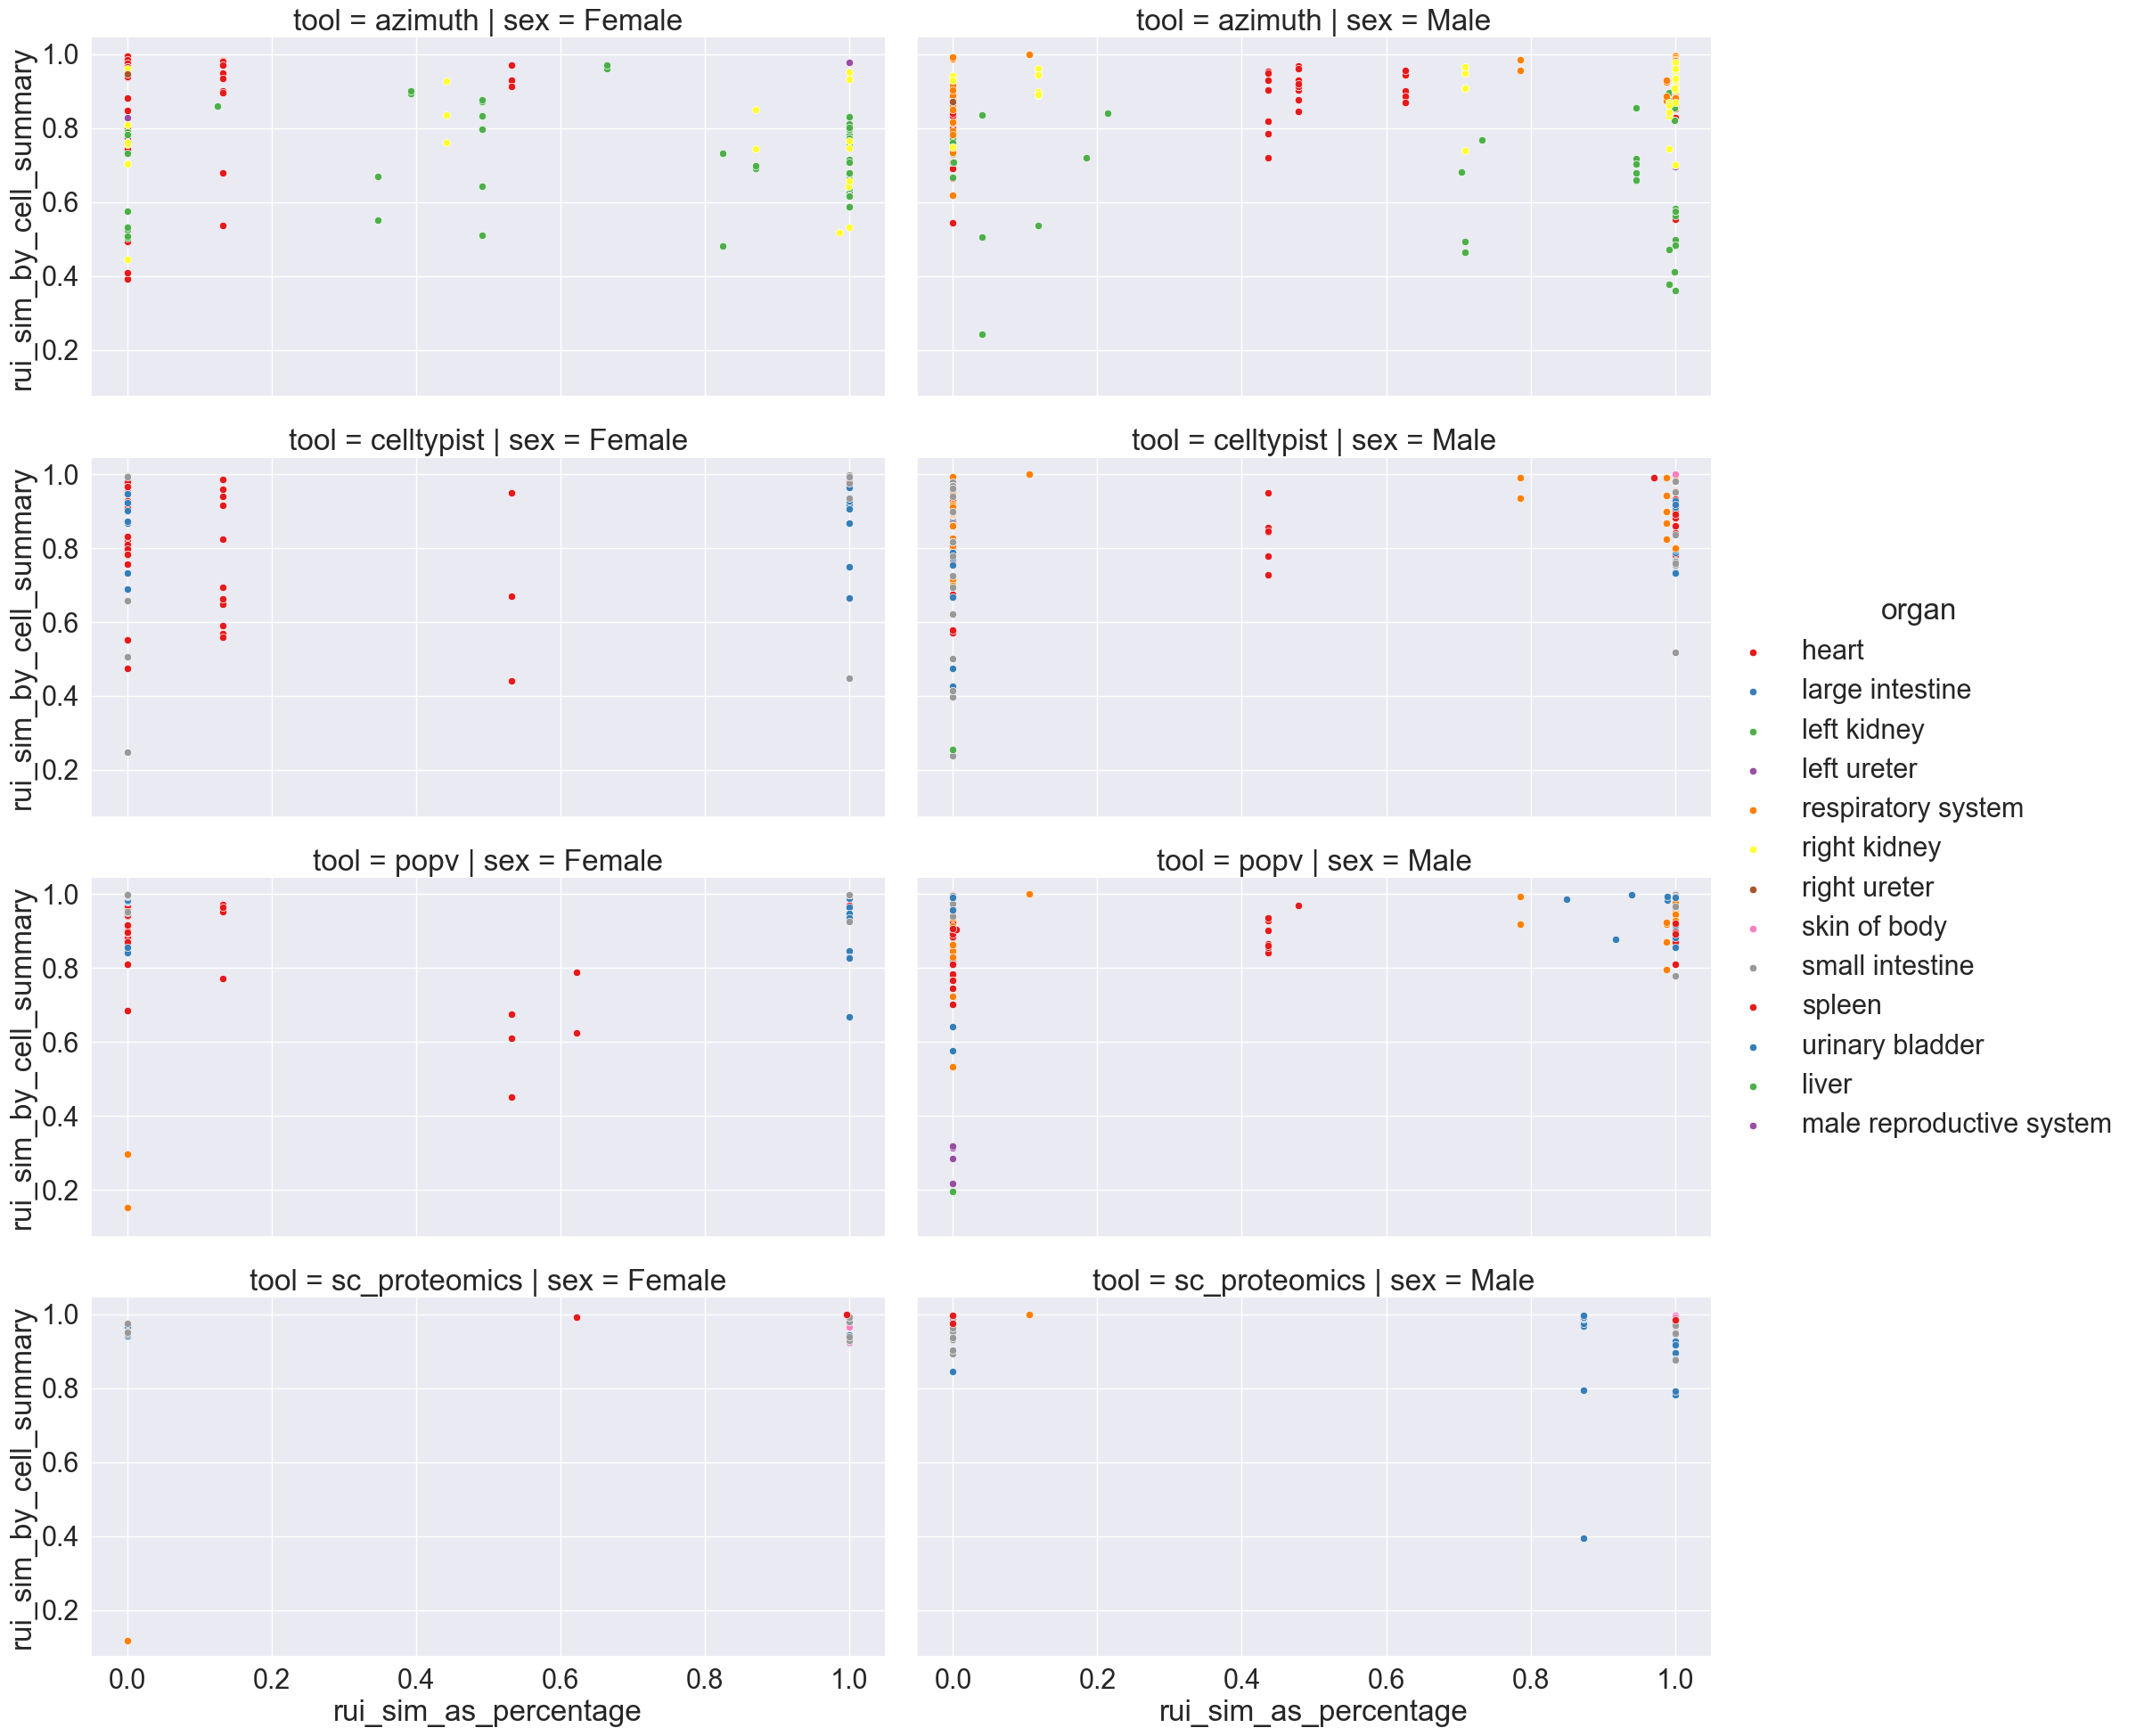

In [22]:
# make scattergraph of rui_sim_by_cell_summary vs rui_sim_as_percentage
make_validation_scattergraph(
    "rui_sim_as_percentage", "rui_sim_by_cell_summary", "Set1", "sex", "tool", "organ", "rui_sim_as_percentage", "rui_sim_by_cell_summary")